In [73]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam # Adam is just like SGD but faster
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import seaborn as sns  # Import Seaborn for the heatmap
import threading
import concurrent.futures
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


# Helper Functions

In [12]:
def print_df_with_all_rows(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('display.max_rows')

def print_df_with_all_cols(df):
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_columns')
    
def print_all_df(df):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

def summary_a_df(df):
    # Summary statistics for numerical columns
    numerical_summary = df.describe()

    # Summary statistics for string columns
    string_summary = df.describe(include=['object'])

    # Combine the summaries
    summary = pd.concat([numerical_summary, string_summary], axis=1)

    # Display the summary in table-like format
    display(summary.style.set_caption("Summary Statistics"))
    
def remove_nan_and_inf(df):
    df = df.dropna(how='any', axis=0, inplace=False)
    inf_condition = (df == np.inf).any(axis=1)
    df = df[~inf_condition]
    return df

def count_labels(df):
    label_counts = df[' Label'].value_counts()

    # Convert the value counts into a DataFrame for better formatting
    label_counts_df = pd.DataFrame(label_counts)

    # Rename the column to make it more descriptive
    label_counts_df.columns = ['Count']

    # Print the table
    display(label_counts_df)
    
def label_coding(df, label):
    label_encoder = LabelEncoder()
    df[label] = label_encoder.fit_transform(df[label])
    return df

In [24]:
import os

# Define the dataset directory path
dataset_dir = './TrafficLabelling/'

# List all CSV files in the dataset directory
csv_files = [file for file in os.listdir(dataset_dir) if file.endswith('.csv')]


# Iterate over each CSV file and read it into a DataFrame
dfs = []
for csv_file in csv_files:
    file_path = os.path.join(dataset_dir, csv_file)
    # Try different encodings until the file is successfully read
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'windows-1252']:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            dfs.append(df)
            break  # Stop trying encodings once the file is successfully read
        except UnicodeDecodeError:
            continue

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)
combined_df = remove_nan_and_inf(combined_df)

summary_a_df(combined_df)

data = combined_df

# drop some unused feature
data = data.drop(columns='Flow ID')

# do label encoding to some feature
label_encoder = LabelEncoder()
data[" Source IP"] = label_encoder.fit_transform(data[" Source IP"])
data[" Source Port"] = label_encoder.fit_transform(data[" Source Port"])
data[" Destination IP"] = label_encoder.fit_transform(data[" Destination IP"])
data[" Destination Port"] = label_encoder.fit_transform(data[" Destination Port"])
data[" Timestamp"] = label_encoder.fit_transform(data[" Timestamp"])

# Shuffle all the rows of the DataFrame
data = data.sample(frac=1).reset_index(drop=True)
summary_a_df(data)

/tmp/ipykernel_847152/1217231969.py:17: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding)


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Flow ID,Source IP,Destination IP,Timestamp,Label
count,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876,2827876,2827876,2827876,2827876
mean,41137.928383,8061.533564,9.884209,14800654.154866,9.368972,10.403958,549.852156,16179.026818,207.804414,18.729293,58.256278,68.978113,871.730371,41.089216,306.257482,335.665686,1491719.064342,70854.233063,1299765.121566,2922230.578133,9191784.833003,162544.187887,14497645.069417,2612839.278845,3270269.378014,9052106.607501,1022928.936049,9903861.062804,1807614.534378,1487479.879304,4689441.933658,968242.014304,0.046396,0.000000,0.000111,0.000000,-26023.794654,-2275.588350,63930.095342,7002.283714,16.448878,951.359143,172.113666,295.271976,486646.832113,0.035283,0.046396,0.000243,0.298284,0.315315,0.094829,0.000111,0.000244,0.683844,192.170727,58.256278,306.257482,-26023.794654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.368972,549.841667,10.403958,16178.686395,6992.388973,1988.289818,5.423519,-2744.494351,81634.000606,41175.819987,153337.823089,58354.920092,8324467.717188,504354.764470,8704568.043331,7928060.620221,nan,nan,nan,nan,nan
std,22291.609424,18274.319686,5.263117,33667504.659191,750.052678,997.893683,9998.638858,2264234.902063,717.518258,60.355329,186.173346,281.321197,1947.156857,68.881178,605.485519,840.050847,25940155.669964,254415.437897,4510039.064694,8049410.125983,24470186.670042,2951772.415426,33589658.917497,9530187.265029,9643378.776399,24539897.649640,8595728.740876,28749449.925980,8891514.923097,6281472.051393,17168998

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876.000000,2827876
mean,4844.182673,40344.067823,6270.696480,6189.285897,9.884209,24518.610137,14800654.154866,9.368972,10.403958,549.852156,16179.026818,207.804414,18.729293,58.256278,68.978113,871.730371,41.089216,306.257482,335.665686,1491719.064342,70854.233063,1299765.121566,2922230.578133,9191784.833003,162544.187887,14497645.069417,2612839.278845,3270269.378014,9052106.607501,1022928.936049,9903861.062804,1807614.534378,1487479.879304,4689441.933658,968242.014304,0.046396,0.000000,0.000111,0.000000,-26023.794654,-2275.588350,63930.095342,7002.283714,16.448878,951.359143,172.113666,295.271976,486646.832113,0.035283,0.046396,0.000243,0.298284,0.315315,0.094829,0.000111,0.000244,0.683844,192.170727,58.256278,306.257482,-26023.794654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.368972,549.841667,10.403958,16178.686395,6992.388973,1988.289818,5.423519,-2744.494351,81634.000606,41175.819987,153337.823089,58354.920092,8324467.717188,504354.764470,8704568.043331,7928060.620221,nan
std,2088.899354,22101.485709,3245.364665,14295.086228,5.263117,6129.296842,33667504.659191,750.052678,997.893683,9998.638858,2264234.902053,717.518258,60.355329,186.173346,281.321197,1947.156857,68.881178,605.485519,840.050847,25940155.669990,254415.437897,4510039.064693,8049410.125970,24470186.670004,2951772.415420,33589658.917503,9530187.265009,9643378.776417,24539897.649471,8595728

get the count of each label

In [25]:
# count_labels(data)
# display(data.head())
print_df_with_all_cols(data.head())

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4714,27172,5453,24,17.0,26663,62413.0,2.0,2.0,70.0,188.0,35.0,35.0,35.00,0.000000,94.0,94.0,94.000000,0.000000,4.133754e+03,64.089212,2.080433e+04,3.602983e+04,62408.0,1.0,1.0,1.0,0.000,1.0,1.0,4.0,4.000,0.000,4.0,4.0,0.0,0.0,0.0,0.0,64.0,64.0,32.044606,32.044606,35.0,94.0,58.600000,32.315631,1044.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,73.250000,35.00,94.000000,64.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,70.0,2.0,188.0,-1.0,-1.0,1.0,32.0,0.0000,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0,BENIGN
1,3542,57548,5455,6131,6.0,27775,45.0,1.0,1.0,0.0,6.0,0.0,0.0,0.00,0.000000,6.0,6.0,6.000000,0.000000,1.333333e+05,44444.444440,4.500000e+01,0.000000e+00,45.0,45.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,40.0,20.0,22222.222220,22222.222220,0.0,6.0,2.000000,3.464102,12.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.000000,0.00,6.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,29200.0,0.0,0.0,40.0,0.0000,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0,PortScan
2,3020,75,5457,41013,6.0,22473,3.0,2.0,0.0,37.0,0.0,31.0,6.0,18.50,17.677670,0.0,0.0,0.000000,0.000000,1.233333e+07,666666.666667,3.000000e+00,0.000000e+00,3.0,3.0,3.0,3.0,0.000,3.0,3.0,0.0,0.000,0.000,0.0,0.0,1.0,0.0,0.0,0.0,40.0,0.0,666666.666667,0.000000,6.0,31.0,22.666667,14.433757,208.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.000000,18.50,0.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,37.0,0.0,0.0,62.0,-1.0,1.0,20.0,0.0000,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0,BENIGN
3,4723,57337,5453,24,17.0,26185,837.0,2.0,2.0,70.0,126.0,35.0,35.0,35.00,0.000000,63.0,63.0,63.000000,0.000000,2.341697e+05,4778.972521,2.790000e+02,4.396510e+02,786.0,3.0,3.0,3.0,0.000,3.0,3.0,48.0,48.000,0.000,48.0,48.0,0.0,0.0,0.0,0.0,40.0,40.0,2389.486260,2389.486260,35.0,63.0,46.200000,15.336232,235.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,57.750000,35.00,63.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,70.0,2.0,126.0,-1.0,-1.0,1.0,20.0,0.0000,0.00000,0.0,0.0,0.000,0.00000,0.0,0.0,BENIGN
4,4712,63076,5831,27,6.0,27200,116233680.0,16.0,13.0,484.0,482.0,400.0,0.0,30.25,98.611358,416.0,0.0,37.076923,113.864292,8.310844e+00,0.249497,4.151203e+06,4.865684e+06,10000000.0,39.0,116000000.0,7748912.0,4183508.428,10100000.0,22681.0,111000000.0,9285003.167,2880632.354,10100000.0,137776.0,0.0,0.0,0.0,0.0,332.0,272.0,0.137654,0.111844,0.0,416.0,32.200000,102.191639,10443.131030,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,33.310345,30.25,37.076923,332.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,484.0,13.0,482.0,8192.0,1024.0,15.0,20.0,131514.6364,56661.43292,302355.0,114253.0,9997616.273,16338.80639,10000000.0,9950056.0,BENIGN


# Get `x` from the dataframe `data`

In [33]:
X = data.drop(columns=' Label')
X = X.values.reshape(-1, X.shape[1]).astype('float32')
standardizer = preprocessing.StandardScaler()
X = standardizer.fit_transform(X)

# Specify the columns you want to standardize
# numeric_columns = df.select_dtypes(include=['number']).columns
# columns_to_scale = [col for col in numeric_columns if col not in ["A", "B", "C"]]
# scaler = StandardScaler()
# data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Get `Y` from the dataframe `data`

In [69]:
y = data.iloc[:, -1:]
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
y = ohe.transform(y)
categories = ohe.categories_

categories_as_list = []
for i, label in enumerate(categories[0]):
    categories_as_list.append(category)
print(len(categories))
print(len(categories_as_list))

display(y)

1
15


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

#  Get training set and test set

In [35]:
X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
y = torch.tensor(y, dtype=torch.float32).to(DEVICE)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([1979513, 83])
torch.Size([848363, 83])
torch.Size([1979513, 15])
torch.Size([848363, 15])


# Defining models

In [39]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(83, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 15)
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

ann = ANN().to(DEVICE)
model = ann

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 300
batch_size = 512
batches_per_epoch = len(X_train) // batch_size
 
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

In [42]:
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

Epoch 0:  39%|███████████████████████████████▍                                                 | 1499/3866 [00:02<00:02, 848.09batch/s, acc=0.994, loss=0.0242]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 0:  97%|█████████████████████████████████████████████████████████████████████████████▍  | 3745/3866 [00:06<00:00, 640.37batch/s, acc=0.998, loss=0.00571]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 1:  55%|██████████████████

Epoch 1 validation: Cross-entropy=0.00, Accuracy=99.9%


Epoch 2:  15%|███████████▉                                                                     | 567/3866 [00:00<00:03, 853.86batch/s, acc=0.998, loss=0.00218]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 2:  74%|█████████████████████████████████████████████████████████████                      | 2845/3866 [00:04<00:01, 880.52batch/s, acc=1, loss=0.000356]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 2: 100%|██████████████████

Epoch 2 validation: Cross-entropy=0.00, Accuracy=99.9%


Epoch 3:  29%|███████████████████████▍                                                        | 1131/3866 [00:01<00:02, 973.84batch/s, acc=0.998, loss=0.00358]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 3:  97%|█████████████████████████████████████████████████████████████████████████████▋  | 3755/3866 [00:05<00:00, 933.70batch/s, acc=0.998, loss=0.00239]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 4:  55%|██████████████████

Epoch 4 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 5:  17%|██████████████▌                                                                     | 673/3866 [00:01<00:03, 828.02batch/s, acc=1, loss=0.000104]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 5:  70%|███████████████████████████████████████████████████████████                          | 2689/3866 [00:04<00:01, 877.88batch/s, acc=1, loss=0.0001]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 5: 100%|██████████████████

Epoch 5 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 6:  27%|█████████████████████▏                                                          | 1025/3866 [00:01<00:03, 901.56batch/s, acc=0.998, loss=0.00227]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 6:  85%|███████████████████████████████████████████████████████████████████████▍            | 3285/3866 [00:04<00:00, 649.01batch/s, acc=1, loss=3.48e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 7:  46%|██████████████████

Epoch 7 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 8:  11%|████████▊                                                                           | 408/3866 [00:00<00:06, 575.73batch/s, acc=1, loss=0.000189]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 8:  73%|████████████████████████████████████████████████████████████▌                      | 2822/3866 [00:04<00:01, 614.21batch/s, acc=1, loss=0.000389]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 8: 100%|██████████████████

Epoch 8 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 9:  36%|██████████████████████████████                                                     | 1402/3866 [00:01<00:02, 903.74batch/s, acc=1, loss=0.000951]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:05<00:00, 739.41batch/s, acc=0.998, loss=0.00214]


Epoch 9 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 10:   2%|█▍                                                                                  | 68/3866 [00:00<00:04, 764.80batch/s, acc=1, loss=0.000111]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 10:  65%|█████████████████████████████████████████████████████▌                            | 2528/3866 [00:03<00:01, 750.17batch/s, acc=1, loss=0.000151]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 10: 100%|█████████████████

Epoch 10 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 11:  31%|████████████████████████▎                                                      | 1188/3866 [00:01<00:04, 613.37batch/s, acc=0.998, loss=0.00874]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 11:  90%|██████████████████████████████████████████████████████████████████████████▎        | 3463/3866 [00:05<00:01, 401.56batch/s, acc=1, loss=8.13e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 12:  52%|█████████████████

Epoch 12 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 13:  15%|████████████▊                                                                       | 589/3866 [00:00<00:05, 619.82batch/s, acc=1, loss=3.78e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 13:  79%|████████████████████████████████████████████████████████████████▊                 | 3057/3866 [00:04<00:00, 856.20batch/s, acc=1, loss=0.000219]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 14:  42%|█████████████████

Epoch 14 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 15:   2%|██                                                                                    | 95/3866 [00:00<00:03, 945.52batch/s, acc=1, loss=0.0012]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 15:  65%|████████████████████████████████████████████████████▉                             | 2496/3866 [00:03<00:01, 816.83batch/s, acc=1, loss=0.000102]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 15: 100%|█████████████████

Epoch 15 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 16:  25%|█████████████████████▎                                                               | 967/3866 [00:01<00:04, 628.21batch/s, acc=1, loss=2.4e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 16:  87%|███████████████████████████████████████████████████████████████████████▋          | 3378/3866 [00:04<00:01, 335.39batch/s, acc=1, loss=0.000146]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 17:  44%|█████████████████

Epoch 18 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 19:  21%|████████████████▋                                                               | 808/3866 [00:01<00:07, 421.22batch/s, acc=0.996, loss=0.00833]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 19:  81%|███████████████████████████████████████████████████████████████████▌               | 3146/3866 [00:04<00:00, 940.92batch/s, acc=1, loss=2.07e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 19: 100%|█████████████████

Epoch 19 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 20:  38%|███████████████████████████████▋                                                   | 1475/3866 [00:02<00:03, 779.31batch/s, acc=1, loss=2.48e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:05<00:00, 683.14batch/s, acc=1, loss=0.00163]


Epoch 20 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 21:   0%|▏                                                                                    | 11/3866 [00:00<00:04, 881.88batch/s, acc=1, loss=3.29e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 21:  60%|███████████████████████████████████████████████▊                               | 2337/3866 [00:03<00:01, 853.68batch/s, acc=0.998, loss=0.00177]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 21: 100%|█████████████████

Epoch 21 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 22:  23%|███████████████████▎                                                                | 888/3866 [00:01<00:03, 799.68batch/s, acc=1, loss=0.00121]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 22:  79%|█████████████████████████████████████████████████████████████████▌                 | 3053/3866 [00:04<00:01, 790.08batch/s, acc=1, loss=2.82e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 23:  43%|█████████████████

Epoch 23 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 24:   2%|██                                                                                   | 92/3866 [00:00<00:05, 744.40batch/s, acc=1, loss=2.12e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 24:  61%|██████████████████████████████████████████████████▌                                | 2356/3866 [00:03<00:01, 818.90batch/s, acc=1, loss=1.45e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 24: 100%|█████████████████

Epoch 24 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 25:  25%|█████████████████████▏                                                              | 977/3866 [00:01<00:03, 725.03batch/s, acc=1, loss=9.68e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 25:  85%|██████████████████████████████████████████████████████████████████████▌            | 3288/3866 [00:04<00:00, 720.05batch/s, acc=1, loss=7.09e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 26:  46%|█████████████████

Epoch 26 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 27:   9%|███████▌                                                                           | 350/3866 [00:00<00:04, 830.38batch/s, acc=1, loss=0.000431]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 27:  68%|████████████████████████████████████████████████████████▍                          | 2626/3866 [00:03<00:01, 909.18batch/s, acc=1, loss=6.79e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 27: 100%|█████████████████

Epoch 27 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 28:  25%|█████████████████████▎                                                              | 981/3866 [00:01<00:03, 759.58batch/s, acc=1, loss=5.16e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 28:  84%|█████████████████████████████████████████████████████████████████████▌             | 3239/3866 [00:04<00:01, 351.79batch/s, acc=1, loss=4.65e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 29:  42%|█████████████████

Epoch 29 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 30:   3%|██▏                                                                                  | 101/3866 [00:00<00:04, 821.22batch/s, acc=1, loss=6.2e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 30:  61%|████████████████████████████████████████████████▍                              | 2370/3866 [00:03<00:02, 704.68batch/s, acc=0.998, loss=0.00279]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 30: 100%|█████████████████

Epoch 30 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 31:  25%|█████████████████████▏                                                              | 975/3866 [00:01<00:05, 542.44batch/s, acc=1, loss=2.48e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 31:  83%|█████████████████████████████████████████████████████████████████████▏             | 3225/3866 [00:04<00:00, 667.68batch/s, acc=1, loss=1.57e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 32:  40%|█████████████████

Epoch 33 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 34:  18%|██████████████▊                                                                     | 683/3866 [00:00<00:03, 912.03batch/s, acc=1, loss=4.78e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 34:  78%|███████████████████████████████████████████████████████████████▉                  | 3014/3866 [00:04<00:01, 621.21batch/s, acc=1, loss=0.000241]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 35:  41%|█████████████████

Epoch 36 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 37:  15%|████████████▉                                                                       | 596/3866 [00:00<00:04, 675.81batch/s, acc=1, loss=4.14e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 37:  76%|█████████████████████████████████████████████████████████████▏                  | 2955/3866 [00:04<00:00, 941.70batch/s, acc=0.998, loss=0.0167]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 37: 100%|█████████████████

Epoch 37 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 38:  30%|█████████████████████████                                                          | 1170/3866 [00:01<00:05, 510.58batch/s, acc=1, loss=2.59e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 38:  84%|█████████████████████████████████████████████████████████████████████▊             | 3251/3866 [00:05<00:01, 499.94batch/s, acc=1, loss=1.68e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 39:  43%|█████████████████

Epoch 39 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 40:   4%|███▎                                                                            | 161/3866 [00:00<00:04, 918.78batch/s, acc=0.998, loss=0.00166]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 40:  61%|█████████████████████████████████████████████████▋                                | 2340/3866 [00:03<00:02, 753.63batch/s, acc=1, loss=0.000156]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 40: 100%|█████████████████

Epoch 40 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 41:  24%|████████████████████▎                                                               | 934/3866 [00:01<00:04, 642.24batch/s, acc=1, loss=6.67e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 41:  86%|██████████████████████████████████████████████████████████████████████▍           | 3323/3866 [00:04<00:00, 841.69batch/s, acc=1, loss=0.000105]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 42:  43%|█████████████████

Epoch 42 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 43:   1%|▍                                                                                     | 21/3866 [00:00<00:05, 687.98batch/s, acc=1, loss=1.5e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 43:  63%|████████████████████████████████████████████████████                               | 2426/3866 [00:03<00:01, 822.21batch/s, acc=1, loss=5.45e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 43: 100%|█████████████████

Epoch 43 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 44:  21%|█████████████████▏                                                                 | 799/3866 [00:01<00:03, 813.33batch/s, acc=1, loss=0.000448]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 44:  79%|█████████████████████████████████████████████████████████████████                 | 3070/3866 [00:04<00:00, 802.67batch/s, acc=1, loss=0.000136]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 45:  43%|█████████████████

Epoch 45 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 46:   4%|███▋                                                                                | 170/3866 [00:00<00:04, 913.73batch/s, acc=1, loss=3.01e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 46:  64%|████████████████████████████████████████████████████▊                              | 2459/3866 [00:03<00:02, 688.36batch/s, acc=1, loss=2.22e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 46: 100%|█████████████████

Epoch 46 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 47:  26%|█████████████████████▊                                                             | 1017/3866 [00:01<00:06, 436.20batch/s, acc=1, loss=4.55e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 47:  88%|████████████████████████████████████████████████████████████████████████▊          | 3392/3866 [00:04<00:00, 500.29batch/s, acc=1, loss=4.77e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 48:  43%|█████████████████

Epoch 48 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 49:   1%|█▎                                                                                   | 57/3866 [00:00<00:04, 923.54batch/s, acc=1, loss=2.17e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 49:  65%|█████████████████████████████████████████████████████▊                             | 2504/3866 [00:03<00:03, 391.42batch/s, acc=1, loss=1.25e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 49: 100%|█████████████████

Epoch 49 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 50:  25%|████████████████████▉                                                               | 966/3866 [00:01<00:03, 842.08batch/s, acc=1, loss=2.91e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 50:  84%|█████████████████████████████████████████████████████████████████████▊             | 3251/3866 [00:04<00:00, 701.56batch/s, acc=1, loss=4.83e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 51:  47%|█████████████████

Epoch 51 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 52:   6%|████▉                                                                              | 231/3866 [00:00<00:09, 383.77batch/s, acc=1, loss=0.000141]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 52:  67%|███████████████████████████████████████████████████████▍                           | 2583/3866 [00:03<00:01, 677.19batch/s, acc=1, loss=2.36e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 52: 100%|█████████████████

Epoch 52 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 53:  25%|█████████████████████▏                                                              | 973/3866 [00:01<00:04, 664.02batch/s, acc=1, loss=3.28e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 53:  88%|█████████████████████████████████████████████████████████████████████████▏         | 3411/3866 [00:04<00:00, 829.42batch/s, acc=1, loss=2.25e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 54:  50%|█████████████████

Epoch 54 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 55:   5%|████▌                                                                                | 207/3866 [00:00<00:06, 603.86batch/s, acc=1, loss=9.9e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 55:  69%|████████████████████████████████████████████████████████▋                         | 2672/3866 [00:03<00:03, 386.72batch/s, acc=1, loss=0.000921]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 55: 100%|█████████████████

Epoch 55 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 56:  32%|█████████████████████████▉                                                        | 1221/3866 [00:01<00:03, 796.76batch/s, acc=1, loss=0.000124]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 56:  93%|████████████████████████████████████████████████████████████████████████████▎     | 3595/3866 [00:05<00:00, 925.10batch/s, acc=1, loss=0.000663]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 57:  52%|█████████████████

Epoch 57 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 58:  13%|██████████▌                                                                         | 484/3866 [00:00<00:03, 903.85batch/s, acc=1, loss=1.83e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 58:  75%|██████████████████████████████████████████████████████████████▍                    | 2910/3866 [00:04<00:01, 664.75batch/s, acc=1, loss=5.49e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 58: 100%|█████████████████

Epoch 58 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 59:  35%|████████████████████████████▋                                                      | 1339/3866 [00:01<00:04, 613.66batch/s, acc=1, loss=6.56e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 59:  99%|██████████████████████████████████████████████████████████████████████████████████ | 3823/3866 [00:05<00:00, 701.55batch/s, acc=1, loss=9.66e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 60:  65%|█████████████████

Epoch 60 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 61:  27%|█████████████████████▋                                                            | 1025/3866 [00:01<00:03, 882.45batch/s, acc=1, loss=0.000613]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 61:  84%|█████████████████████████████████████████████████████████████████████▍             | 3234/3866 [00:05<00:00, 962.54batch/s, acc=1, loss=2.29e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 62:  44%|█████████████████

Epoch 62 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 63:   7%|█████▊                                                                             | 271/3866 [00:00<00:06, 568.78batch/s, acc=1, loss=0.000751]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 63:  64%|██████████████████████████████████████████████████▊                            | 2485/3866 [00:03<00:01, 893.77batch/s, acc=0.998, loss=0.00335]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 63: 100%|█████████████████

Epoch 63 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 64:  30%|████████████████████████▉                                                          | 1162/3866 [00:01<00:03, 865.12batch/s, acc=1, loss=8.72e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 64:  92%|████████████████████████████████████████████████████████████████████████████▋      | 3574/3866 [00:04<00:00, 659.30batch/s, acc=1, loss=1.98e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 65:  55%|█████████████████

Epoch 65 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 66:  17%|██████████████▎                                                                    | 666/3866 [00:00<00:09, 342.33batch/s, acc=1, loss=0.000824]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 66:  79%|██████████████████████████████████████████████████████████████████▎                 | 3051/3866 [00:04<00:01, 550.19batch/s, acc=1, loss=3.8e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 66: 100%|█████████████████

Epoch 66 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 67:  39%|████████████████████████████████                                                   | 1494/3866 [00:02<00:03, 709.43batch/s, acc=1, loss=4.59e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 67:  95%|█████████████████████████████████████████████████████████████████████████████▋    | 3661/3866 [00:05<00:00, 772.37batch/s, acc=1, loss=0.000331]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 68:  59%|█████████████████

Epoch 68 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 69:  24%|████████████████████                                                                | 923/3866 [00:01<00:03, 830.22batch/s, acc=1, loss=7.57e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 69:  82%|███████████████████████████████████████████████████████████████████▋               | 3154/3866 [00:04<00:00, 865.76batch/s, acc=1, loss=1.59e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 70:  40%|█████████████████

Epoch 70 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 71:   5%|███▉                                                                             | 185/3866 [00:00<00:04, 856.38batch/s, acc=0.998, loss=0.0113]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 71:  66%|██████████████████████████████████████████████████████▋                            | 2546/3866 [00:03<00:01, 722.53batch/s, acc=1, loss=1.65e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 71: 100%|█████████████████

Epoch 71 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 72:  26%|█████████████████████▋                                                             | 1013/3866 [00:01<00:03, 881.25batch/s, acc=1, loss=8.16e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 72:  86%|███████████████████████████████████████████████████████████████████████▌           | 3331/3866 [00:04<00:00, 639.43batch/s, acc=1, loss=5.83e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 73:  49%|█████████████████

Epoch 73 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 74:   9%|███████▍                                                                           | 346/3866 [00:00<00:05, 657.74batch/s, acc=1, loss=0.000137]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 74:  70%|██████████████████████████████████████████████████████████▏                        | 2709/3866 [00:03<00:02, 568.28batch/s, acc=1, loss=2.19e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 74: 100%|█████████████████

Epoch 74 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 75:  33%|███████████████████████████▍                                                       | 1279/3866 [00:01<00:03, 805.75batch/s, acc=1, loss=4.44e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 75:  95%|███████████████████████████████████████████████████████████████████████████▏   | 3680/3866 [00:05<00:00, 876.90batch/s, acc=0.998, loss=0.00163]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 76:  59%|█████████████████

Epoch 76 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 77:  21%|█████████████████                                                               | 824/3866 [00:01<00:07, 425.66batch/s, acc=0.998, loss=0.00594]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 77:  80%|██████████████████████████████████████████████████████████████████▌                | 3100/3866 [00:04<00:01, 732.41batch/s, acc=1, loss=2.11e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 78:  39%|█████████████████

Epoch 79 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 80:  38%|███████████████████████████████▌                                                    | 1451/3866 [00:01<00:02, 862.35batch/s, acc=1, loss=1.4e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 846.61batch/s, acc=1, loss=0.000978]


Epoch 80 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 81:  13%|███████████                                                                         | 509/3866 [00:00<00:03, 957.41batch/s, acc=1, loss=4.25e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 81:  90%|██████████████████████████████████████████████████████████████████████████▍        | 3468/3866 [00:03<00:00, 902.07batch/s, acc=1, loss=8.73e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 82:  65%|█████████████████

Epoch 83 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 84:  17%|██████████████▎                                                                    | 669/3866 [00:00<00:05, 638.39batch/s, acc=1, loss=0.000587]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 84:  91%|███████████████████████████████████████████████████████████████████████████▊       | 3534/3866 [00:04<00:00, 904.15batch/s, acc=1, loss=6.57e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 85:  65%|█████████████████

Epoch 86 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 87:  18%|██████████████▉                                                                     | 690/3866 [00:00<00:03, 832.06batch/s, acc=1, loss=8.99e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 87:  92%|████████████████████████████████████████████████████████████████████████████▍      | 3560/3866 [00:04<00:00, 765.31batch/s, acc=1, loss=2.37e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 88:  65%|█████████████████

Epoch 89 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 90:  14%|███████████▍                                                                        | 527/3866 [00:00<00:03, 951.84batch/s, acc=1, loss=6.88e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 90:  89%|██████████████████████████████████████████████████████████████████████████         | 3449/3866 [00:03<00:00, 892.51batch/s, acc=1, loss=8.31e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 91:  65%|█████████████████

Epoch 91 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 92:  36%|█████████████████████████████▋                                                     | 1385/3866 [00:01<00:02, 943.94batch/s, acc=1, loss=2.18e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 859.88batch/s, acc=1, loss=0.000851]


Epoch 92 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 93:  12%|██████████▏                                                                         | 471/3866 [00:00<00:03, 910.59batch/s, acc=1, loss=1.29e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 93:  86%|██████████████████████████████████████████████████████████████████████▊           | 3337/3866 [00:03<00:00, 925.09batch/s, acc=1, loss=0.000405]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 94:  62%|█████████████████

Epoch 94 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 95:  36%|█████████████████████████████▊                                                    | 1405/3866 [00:01<00:02, 957.16batch/s, acc=1, loss=0.000327]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 95: 100%|███████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 864.52batch/s, acc=0.998, loss=0.00233]


Epoch 95 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 96:  13%|██████████▌                                                                         | 487/3866 [00:00<00:03, 899.78batch/s, acc=1, loss=1.78e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 96:  87%|████████████████████████████████████████████████████████████████████████           | 3359/3866 [00:03<00:00, 917.53batch/s, acc=1, loss=1.17e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 97:  62%|█████████████████

Epoch 97 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 98:  33%|███████████████████████████▋                                                       | 1292/3866 [00:01<00:02, 979.69batch/s, acc=1, loss=3.46e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 98: 100%|███████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 862.32batch/s, acc=0.998, loss=0.00185]


Epoch 98 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 99:  10%|████████▏                                                                           | 375/3866 [00:00<00:03, 902.96batch/s, acc=1, loss=5.12e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 99:  82%|████████████████████████████████████████████████████████████████████▍              | 3186/3866 [00:03<00:00, 828.65batch/s, acc=1, loss=3.57e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 100:  55%|████████████████

Epoch 100 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 101:  29%|████████████████████████                                                          | 1133/3866 [00:01<00:03, 705.49batch/s, acc=1, loss=1.03e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 848.14batch/s, acc=1, loss=0.000816]


Epoch 101 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 102:   3%|██▎                                                                                 | 107/3866 [00:00<00:04, 758.63batch/s, acc=1, loss=1.6e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 102:  76%|█████████████████████████████████████████████████████████████▋                   | 2944/3866 [00:03<00:01, 898.12batch/s, acc=1, loss=0.000501]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 103:  51%|████████████████

Epoch 103 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 104:  25%|████████████████████▉                                                              | 974/3866 [00:01<00:03, 887.73batch/s, acc=1, loss=1.86e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 104: 100%|███████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 861.60batch/s, acc=1, loss=0.0015]


Epoch 104 validation: Cross-entropy=0.00, Accuracy=100.0%


  0%|                                                                                                                              | 0/3866 [00:00<?, ?batch/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 105:  75%|█████████████████████████████████████████████████████████████▏                    | 2884/3866 [00:03<00:01, 895.59batch/s, acc=1, loss=4.76e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 106:  49%|████████████████

Epoch 106 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 107:  24%|███████████████████▊                                                               | 921/3866 [00:01<00:03, 898.75batch/s, acc=1, loss=1.05e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████▉| 3861/3866 [00:04<00:00, 892.11batch/s, acc=1, loss=4.12e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 108:  73%|████████████████

Epoch 109 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 110:  18%|███████████████                                                                    | 701/3866 [00:00<00:04, 781.35batch/s, acc=1, loss=5.67e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 110:  91%|██████████████████████████████████████████████████████████████████████████▋       | 3520/3866 [00:04<00:00, 901.33batch/s, acc=1, loss=6.53e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 111:  66%|████████████████

Epoch 111 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 112:  39%|████████████████████████████████▏                                                  | 1497/3866 [00:01<00:02, 864.23batch/s, acc=1, loss=4.6e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 112: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 851.84batch/s, acc=1, loss=0.00103]


Epoch 112 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 113:  14%|███████████▍                                                                      | 537/3866 [00:00<00:03, 897.72batch/s, acc=1, loss=0.000159]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 113:  86%|██████████████████████████████████████████████████████████████████████▊           | 3337/3866 [00:03<00:00, 909.11batch/s, acc=1, loss=3.19e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 114:  61%|████████████████

Epoch 114 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 115:  37%|██████████████████████████████▏                                                   | 1425/3866 [00:01<00:02, 922.94batch/s, acc=1, loss=4.67e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 847.69batch/s, acc=1, loss=0.000733]


Epoch 115 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 116:  11%|████████▊                                                                         | 414/3866 [00:00<00:03, 893.14batch/s, acc=1, loss=0.000631]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 116:  85%|█████████████████████████████████████████████████████████████████▉            | 3267/3866 [00:03<00:00, 961.80batch/s, acc=0.998, loss=0.00241]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 117:  57%|████████████████

Epoch 117 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 118:  31%|█████████████████████████▏                                                        | 1186/3866 [00:01<00:03, 674.35batch/s, acc=1, loss=1.48e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 118: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 867.64batch/s, acc=1, loss=0.00101]


Epoch 118 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 119:   6%|████▉                                                                              | 229/3866 [00:00<00:05, 712.47batch/s, acc=1, loss=6.67e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 119:  80%|█████████████████████████████████████████████████████████████████▉                | 3111/3866 [00:03<00:01, 699.53batch/s, acc=1, loss=1.39e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 120:  52%|████████████████

Epoch 120 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 121:  28%|██████████████████████▋                                                           | 1070/3866 [00:01<00:03, 881.53batch/s, acc=1, loss=1.33e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 121: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 850.56batch/s, acc=1, loss=0.00051]


Epoch 121 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 122:   2%|██                                                                                  | 94/3866 [00:00<00:03, 971.47batch/s, acc=1, loss=2.44e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 122:  74%|████████████████████████████████████████████████████████████▋                     | 2864/3866 [00:03<00:01, 911.52batch/s, acc=1, loss=8.21e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 123:  48%|████████████████

Epoch 123 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 124:  22%|█████████████████▉                                                                 | 836/3866 [00:00<00:03, 842.50batch/s, acc=1, loss=2.86e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 124:  95%|█████████████████████████████████████████████████████████████████████████████    | 3677/3866 [00:04<00:00, 911.14batch/s, acc=1, loss=0.000124]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 125:  71%|████████████████

Epoch 126 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 127:  21%|█████████████████▌                                                                | 827/3866 [00:01<00:03, 915.65batch/s, acc=1, loss=0.000672]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 127:  95%|█████████████████████████████████████████████████████████████████████████████▊    | 3670/3866 [00:04<00:00, 841.66batch/s, acc=1, loss=8.38e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 128:  68%|████████████████

Epoch 129 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 130:  18%|██████████████▉                                                                    | 695/3866 [00:00<00:03, 908.33batch/s, acc=1, loss=4.57e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 130:  92%|███████████████████████████████████████████████████████████████████████████       | 3538/3866 [00:04<00:00, 711.60batch/s, acc=1, loss=0.00012]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 131:  63%|████████████████

Epoch 131 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 132:  39%|███████████████████████████████▊                                                  | 1498/3866 [00:01<00:02, 927.36batch/s, acc=1, loss=7.81e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 850.57batch/s, acc=1, loss=0.000495]


Epoch 132 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 133:  14%|███████████▋                                                                       | 545/3866 [00:00<00:03, 937.97batch/s, acc=1, loss=6.39e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 133:  87%|███████████████████████████████████████████████████████████████████████▏          | 3355/3866 [00:04<00:00, 876.67batch/s, acc=1, loss=1.66e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 134:  60%|████████████████

Epoch 134 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 135:  35%|█████████████████████████████▎                                                     | 1366/3866 [00:01<00:02, 861.95batch/s, acc=1, loss=3.4e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 830.73batch/s, acc=1, loss=0.000449]


Epoch 135 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 136:   8%|██████▊                                                                           | 319/3866 [00:00<00:05, 655.14batch/s, acc=1, loss=0.000194]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 136:  80%|█████████████████████████████████████████████████████████████████▋                | 3095/3866 [00:03<00:00, 964.64batch/s, acc=1, loss=1.05e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 137:  54%|████████████████

Epoch 137 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 138:  30%|████████████████████████▍                                                         | 1150/3866 [00:01<00:02, 953.45batch/s, acc=1, loss=6.13e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 841.29batch/s, acc=1, loss=0.000953]


Epoch 138 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 139:   3%|██                                                                                  | 97/3866 [00:00<00:04, 918.79batch/s, acc=1, loss=6.77e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 139:  76%|██████████████████████████████████████████████████████████████▌                   | 2949/3866 [00:03<00:01, 642.26batch/s, acc=1, loss=2.55e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 140:  50%|████████████████

Epoch 140 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 141:  24%|██████████████████▋                                                            | 917/3866 [00:01<00:03, 781.17batch/s, acc=0.998, loss=0.00973]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 141:  98%|████████████████████████████████████████████████████████████████████████████████▌ | 3800/3866 [00:04<00:00, 984.59batch/s, acc=1, loss=4.82e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 142:  73%|████████████████

Epoch 143 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 144:  23%|██████████████████▋                                                                | 872/3866 [00:01<00:03, 874.94batch/s, acc=1, loss=9.75e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 144:  97%|███████████████████████████████████████████████████████████████████████████████▎  | 3741/3866 [00:04<00:00, 912.63batch/s, acc=1, loss=2.97e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 145:  69%|████████████████

Epoch 146 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 147:  17%|██████████████▎                                                                   | 674/3866 [00:00<00:03, 876.30batch/s, acc=1, loss=0.000665]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 147:  93%|████████████████████████████████████████████████████████████████████████████▍     | 3604/3866 [00:04<00:00, 778.45batch/s, acc=1, loss=1.19e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 148:  67%|████████████████

Epoch 149 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 150:  14%|███████████▎                                                                       | 526/3866 [00:00<00:04, 808.14batch/s, acc=1, loss=3.11e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 150:  88%|███████████████████████████████████████████████████████████████████████▊          | 3388/3866 [00:03<00:00, 902.49batch/s, acc=1, loss=4.56e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 151:  62%|████████████████

Epoch 151 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 152:  36%|█████████████████████████████▍                                                   | 1403/3866 [00:01<00:02, 894.97batch/s, acc=1, loss=0.000269]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 152: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 844.53batch/s, acc=1, loss=0.000975]


Epoch 152 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 153:  10%|███████▉                                                                           | 368/3866 [00:00<00:04, 762.21batch/s, acc=1, loss=1.26e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 153:  83%|████████████████████████████████████████████████████████████████████              | 3209/3866 [00:03<00:00, 905.98batch/s, acc=1, loss=2.45e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 154:  59%|████████████████

Epoch 154 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 155:  34%|███████████████████████████▉                                                      | 1320/3866 [00:01<00:02, 907.22batch/s, acc=1, loss=6.91e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 155: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 852.23batch/s, acc=1, loss=0.00134]


Epoch 155 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 156:   9%|███████▍                                                                           | 346/3866 [00:00<00:06, 536.86batch/s, acc=1, loss=5.35e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 156:  83%|███████████████████████████████████████████████████████████████████▏             | 3204/3866 [00:03<00:00, 876.37batch/s, acc=1, loss=0.000104]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 157:  56%|████████████████

Epoch 157 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 158:  30%|████████████████████████▋                                                         | 1161/3866 [00:01<00:02, 906.46batch/s, acc=1, loss=2.13e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 158: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 858.51batch/s, acc=1, loss=0.00063]


Epoch 158 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 159:   4%|███▎                                                                               | 157/3866 [00:00<00:05, 721.18batch/s, acc=1, loss=7.42e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 159:  77%|███████████████████████████████████████████████████████████████▍                  | 2992/3866 [00:03<00:00, 948.83batch/s, acc=1, loss=6.92e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 160:  52%|████████████████

Epoch 160 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 161:  28%|██████████████████████▊                                                          | 1091/3866 [00:01<00:03, 765.56batch/s, acc=1, loss=0.000721]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 161: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 857.66batch/s, acc=1, loss=0.00144]


Epoch 161 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 162:   3%|██▏                                                                                 | 102/3866 [00:00<00:11, 319.19batch/s, acc=1, loss=1.3e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 162:  77%|███████████████████████████████████████████████████████████▋                  | 2961/3866 [00:03<00:00, 934.05batch/s, acc=0.998, loss=0.00151]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 163:  51%|████████████████

Epoch 163 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 164:  26%|█████████████████████▌                                                            | 1017/3866 [00:01<00:03, 901.00batch/s, acc=1, loss=4.73e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 164:  99%|█████████████████████████████████████████████████████████████████████████████████▏| 3829/3866 [00:04<00:00, 837.21batch/s, acc=1, loss=4.88e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 165:  73%|████████████████

Epoch 166 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 167:  20%|████████████████▉                                                                  | 790/3866 [00:00<00:03, 905.22batch/s, acc=1, loss=1.02e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 167:  95%|██████████████████████████████████████████████████████████████████████████████▏   | 3686/3866 [00:04<00:00, 868.92batch/s, acc=1, loss=1.52e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 168:  70%|████████████████

Epoch 169 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 170:  19%|███████████████▎                                                                   | 716/3866 [00:00<00:03, 908.48batch/s, acc=1, loss=2.75e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 170:  92%|██████████████████████████████████████████████████████████████████████████████▏      | 3555/3866 [00:04<00:00, 891.78batch/s, acc=1, loss=1e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 171:  65%|████████████████

Epoch 172 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 173:  14%|███████████▌                                                                       | 539/3866 [00:00<00:04, 815.92batch/s, acc=1, loss=3.35e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 173:  90%|█████████████████████████████████████████████████████████████████████████▏       | 3496/3866 [00:03<00:00, 877.10batch/s, acc=1, loss=0.000282]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 174:  65%|████████████████

Epoch 174 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 175:  38%|███████████████████████████████▉                                                   | 1488/3866 [00:01<00:02, 878.91batch/s, acc=1, loss=4.1e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 175: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 854.69batch/s, acc=1, loss=0.000501]


Epoch 175 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 176:  12%|██████████                                                                         | 471/3866 [00:00<00:03, 871.08batch/s, acc=1, loss=3.27e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 176:  87%|███████████████████████████████████████████████████████████████████████▋          | 3381/3866 [00:03<00:00, 923.09batch/s, acc=1, loss=1.98e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 177:  61%|████████████████

Epoch 177 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 178:  34%|███████████████████████████▉                                                      | 1315/3866 [00:01<00:02, 897.00batch/s, acc=1, loss=2.45e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 178: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 846.39batch/s, acc=1, loss=0.00103]


Epoch 178 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 179:   8%|███████                                                                            | 327/3866 [00:00<00:05, 705.02batch/s, acc=1, loss=2.93e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 179:  81%|██████████████████████████████████████████████████████████████████▏               | 3119/3866 [00:03<00:00, 881.01batch/s, acc=1, loss=2.16e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 180:  54%|████████████████

Epoch 180 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 181:  27%|█████████████████████▉                                                            | 1037/3866 [00:01<00:02, 952.06batch/s, acc=1, loss=1.23e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 181: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 845.39batch/s, acc=1, loss=0.00107]


Epoch 181 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 182:   1%|▌                                                                                   | 24/3866 [00:00<00:04, 867.24batch/s, acc=1, loss=1.48e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 182:  73%|██████████████████████████████████████████████████████████▊                      | 2807/3866 [00:03<00:01, 906.61batch/s, acc=1, loss=0.000381]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 183:  51%|████████████████

Epoch 183 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 184:  25%|███████████████████▌                                                           | 960/3866 [00:01<00:03, 791.81batch/s, acc=0.998, loss=0.00559]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 184: 100%|█████████████████████████████████████████████████████████████████████████████████▊| 3856/3866 [00:04<00:00, 901.21batch/s, acc=1, loss=1.39e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 185:  75%|████████████████

Epoch 186 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 187:  24%|███████████████████▉                                                               | 931/3866 [00:01<00:03, 862.59batch/s, acc=1, loss=1.45e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 187:  96%|███████████████████████████████████████████████████████████████████████████████   | 3725/3866 [00:04<00:00, 859.75batch/s, acc=1, loss=6.27e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 188:  71%|████████████████

Epoch 189 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 190:  16%|████████████▊                                                                     | 605/3866 [00:00<00:04, 708.86batch/s, acc=1, loss=0.000142]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 190:  90%|█████████████████████████████████████████████████████████████████████████▌        | 3469/3866 [00:04<00:00, 833.54batch/s, acc=1, loss=4.44e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 191:  64%|████████████████

Epoch 192 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 193:  17%|██████████████▎                                                                    | 665/3866 [00:00<00:03, 933.28batch/s, acc=1, loss=2.72e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 193:  93%|███████████████████████████████████████████████████████████████████████████▉      | 3580/3866 [00:04<00:00, 888.21batch/s, acc=1, loss=4.85e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 194:  67%|████████████████

Epoch 195 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 196:  15%|███████████▍                                                                   | 561/3866 [00:00<00:03, 872.85batch/s, acc=0.998, loss=0.00429]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 196:  89%|█████████████████████████████████████████████████████████████████████         | 3424/3866 [00:03<00:00, 986.84batch/s, acc=0.998, loss=0.00448]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 197:  62%|████████████████

Epoch 197 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 198:  36%|█████████████████████████████▌                                                    | 1395/3866 [00:01<00:02, 831.23batch/s, acc=1, loss=1.11e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 198: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 862.73batch/s, acc=1, loss=0.000651]


Epoch 198 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 199:  12%|█████████▊                                                                          | 454/3866 [00:00<00:03, 870.60batch/s, acc=1, loss=8.8e-8]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 199:  85%|██████████████████████████████████████████████████████████████████████            | 3304/3866 [00:03<00:00, 972.71batch/s, acc=1, loss=1.98e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 200:  60%|████████████████

Epoch 200 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 201:  34%|███████████████████████████▋                                                      | 1304/3866 [00:01<00:02, 960.35batch/s, acc=1, loss=2.58e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 201: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 851.41batch/s, acc=1, loss=0.000725]


Epoch 201 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 202:   8%|██████▍                                                                            | 297/3866 [00:00<00:05, 692.26batch/s, acc=1, loss=0.00135]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 202:  82%|███████████████████████████████████████████████████████████████████▍              | 3180/3866 [00:03<00:00, 840.71batch/s, acc=1, loss=6.13e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 203:  58%|████████████████

Epoch 203 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 204:  33%|█████████████████████████▉                                                    | 1287/3866 [00:01<00:02, 887.21batch/s, acc=0.998, loss=0.00142]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 204: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 863.43batch/s, acc=1, loss=0.000689]


Epoch 204 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 205:   8%|██████▋                                                                            | 310/3866 [00:00<00:03, 938.84batch/s, acc=1, loss=4.25e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 205:  84%|████████████████████████████████████████████████████████████████████▉             | 3249/3866 [00:03<00:00, 880.52batch/s, acc=1, loss=9.33e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 206:  60%|████████████████

Epoch 206 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 207:  32%|██████████████████████████▌                                                       | 1254/3866 [00:01<00:03, 856.14batch/s, acc=1, loss=1.77e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 207: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 835.23batch/s, acc=1, loss=0.000555]


Epoch 207 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 208:   7%|██████▏                                                                            | 286/3866 [00:00<00:04, 755.26batch/s, acc=1, loss=1.06e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 208:  80%|██████████████████████████████████████████████████████████████████                | 3112/3866 [00:03<00:01, 621.65batch/s, acc=1, loss=4.74e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 209:  57%|████████████████

Epoch 209 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 210:  31%|█████████████████████████▋                                                         | 1198/3866 [00:01<00:03, 760.83batch/s, acc=1, loss=9.2e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 210: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 836.20batch/s, acc=1, loss=0.000565]


Epoch 210 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 211:   4%|███▏                                                                               | 149/3866 [00:00<00:04, 874.66batch/s, acc=1, loss=7.19e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 211:  78%|███████████████████████████████████████████████████████████████▊                  | 3011/3866 [00:03<00:00, 865.63batch/s, acc=1, loss=0.00194]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 212:  54%|████████████████

Epoch 212 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 213:  27%|██████████████████████▏                                                           | 1048/3866 [00:01<00:03, 901.68batch/s, acc=1, loss=1.16e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 213: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 845.05batch/s, acc=1, loss=0.000286]


Epoch 213 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 214:   0%|▎                                                                                   | 16/3866 [00:00<00:05, 755.24batch/s, acc=1, loss=4.24e-8]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 214:  75%|█████████████████████████████████████████████████████████████▎                    | 2893/3866 [00:03<00:01, 611.39batch/s, acc=1, loss=8.29e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 215:  49%|████████████████

Epoch 215 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 216:  23%|██████████████████▍                                                               | 871/3866 [00:01<00:04, 734.56batch/s, acc=1, loss=0.000373]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 216:  94%|█████████████████████████████████████████████████████████████████████████████     | 3633/3866 [00:04<00:00, 880.98batch/s, acc=1, loss=8.87e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 217:  68%|████████████████

Epoch 218 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 219:  16%|█████████████▎                                                                     | 622/3866 [00:00<00:03, 824.09batch/s, acc=1, loss=7.67e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 219:  90%|██████████████████████████████████████████████████████████████████████▎       | 3487/3866 [00:04<00:00, 877.64batch/s, acc=0.996, loss=0.00396]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 220:  64%|████████████████

Epoch 221 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 222:  14%|████████████▎                                                                         | 556/3866 [00:00<00:03, 903.50batch/s, acc=1, loss=1e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 222:  90%|█████████████████████████████████████████████████████████████████████████▋        | 3477/3866 [00:03<00:00, 909.90batch/s, acc=1, loss=5.59e-8]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 223:  66%|████████████████

Epoch 224 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 225:  12%|█████████▊                                                                         | 455/3866 [00:00<00:03, 910.20batch/s, acc=1, loss=7.31e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 225:  87%|███████████████████████████████████████████████████████████████████████▋          | 3377/3866 [00:03<00:00, 786.86batch/s, acc=1, loss=6.96e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 226:  62%|████████████████

Epoch 226 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 227:  38%|██████████████████████████████▉                                                   | 1460/3866 [00:01<00:02, 876.14batch/s, acc=1, loss=1.44e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 227: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 862.32batch/s, acc=1, loss=0.000519]


Epoch 227 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 228:  13%|██████████▊                                                                        | 504/3866 [00:00<00:03, 881.31batch/s, acc=1, loss=2.13e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 228:  88%|███████████████████████████████████████████████████████████████████████▊          | 3386/3866 [00:03<00:00, 883.75batch/s, acc=1, loss=2.05e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 229:  63%|████████████████

Epoch 229 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 230:  37%|██████████████████████████████▌                                                   | 1441/3866 [00:01<00:02, 909.79batch/s, acc=1, loss=4.64e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 230: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 829.32batch/s, acc=1, loss=0.000636]


Epoch 230 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 231:  10%|████████▎                                                                          | 389/3866 [00:00<00:03, 918.16batch/s, acc=1, loss=0.00122]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 231:  84%|████████████████████████████████████████████████████████████████████▉             | 3248/3866 [00:03<00:00, 897.24batch/s, acc=1, loss=0.00122]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 232:  58%|████████████████

Epoch 232 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 233:  34%|███████████████████████████▊                                                     | 1325/3866 [00:01<00:03, 792.13batch/s, acc=1, loss=0.000129]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 233: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 846.78batch/s, acc=1, loss=0.000595]


Epoch 233 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 234:   8%|██████▋                                                                             | 309/3866 [00:00<00:04, 736.29batch/s, acc=1, loss=9.5e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 234:  83%|███████████████████████████████████████████████████████████████████▊              | 3198/3866 [00:03<00:00, 879.76batch/s, acc=1, loss=1.64e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 235:  55%|████████████████

Epoch 235 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 236:  28%|██████████████████████▉                                                           | 1084/3866 [00:01<00:03, 901.56batch/s, acc=1, loss=1.99e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 236: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 855.04batch/s, acc=1, loss=0.000665]


Epoch 236 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 237:   3%|██▍                                                                                | 116/3866 [00:00<00:04, 928.06batch/s, acc=1, loss=5.31e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 237:  77%|███████████████████████████████████████████████████████████████▌                  | 2996/3866 [00:03<00:00, 922.61batch/s, acc=1, loss=3.95e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 238:  51%|████████████████

Epoch 238 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 239:  25%|████████████████████▉                                                              | 978/3866 [00:01<00:03, 917.36batch/s, acc=1, loss=1.27e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 239: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 865.58batch/s, acc=1, loss=0.00134]


Epoch 239 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 240:   0%|                                                                                     | 5/3866 [00:00<00:06, 617.88batch/s, acc=1, loss=2.63e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 240:  74%|████████████████████████████████████████████████████████████▌                     | 2857/3866 [00:03<00:01, 895.55batch/s, acc=1, loss=6.15e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 241:  50%|████████████████

Epoch 241 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 242:  27%|█████████████████████▌                                                           | 1028/3866 [00:01<00:03, 838.62batch/s, acc=1, loss=0.000695]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 242:  99%|█████████████████████████████████████████████████████████████████████████████████▎| 3831/3866 [00:04<00:00, 899.44batch/s, acc=1, loss=1.37e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 243:  74%|████████████████

Epoch 244 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 245:  22%|██████████████████▍                                                               | 869/3866 [00:01<00:03, 917.65batch/s, acc=1, loss=0.000106]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 245:  97%|███████████████████████████████████████████████████████████████████████████████▍  | 3746/3866 [00:04<00:00, 913.56batch/s, acc=1, loss=1.12e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 246:  71%|████████████████

Epoch 247 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 248:  24%|████████████████████                                                               | 932/3866 [00:01<00:03, 758.34batch/s, acc=1, loss=6.21e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 248:  98%|█████████████████████████████████████████████████████████████████████████████████▏ | 3780/3866 [00:04<00:00, 759.30batch/s, acc=1, loss=1.5e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 249:  71%|████████████████

Epoch 250 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 251:  18%|██████████████▉                                                                    | 694/3866 [00:00<00:04, 767.47batch/s, acc=1, loss=1.38e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 251:  91%|█████████████████████████████████████████████████████████████████████████▉       | 3531/3866 [00:04<00:00, 864.45batch/s, acc=1, loss=0.000218]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 252:  68%|████████████████

Epoch 253 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 254:  19%|███████████████▍                                                                   | 721/3866 [00:00<00:03, 858.37batch/s, acc=1, loss=3.34e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 254:  92%|████████████████████████████████████████████████████████████████████████████▌      | 3569/3866 [00:04<00:00, 882.94batch/s, acc=1, loss=2.6e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 255:  66%|████████████████

Epoch 256 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 257:  13%|██████████▏                                                                    | 499/3866 [00:00<00:03, 915.65batch/s, acc=0.998, loss=0.00219]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 257:  85%|█████████████████████████████████████████████████████████████████████▋            | 3286/3866 [00:03<00:00, 869.27batch/s, acc=1, loss=3.78e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 258:  59%|████████████████

Epoch 258 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 259:  32%|██████████████████████████▌                                                       | 1251/3866 [00:01<00:03, 827.97batch/s, acc=1, loss=4.74e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 259: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 827.99batch/s, acc=1, loss=0.00076]


Epoch 259 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 260:   4%|███▍                                                                               | 158/3866 [00:00<00:03, 953.38batch/s, acc=1, loss=6.45e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 260:  79%|████████████████████████████████████████████████████████████████▉                 | 3059/3866 [00:03<00:01, 714.05batch/s, acc=1, loss=4.96e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 261:  50%|████████████████

Epoch 261 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 262:  24%|███████████████████▉                                                               | 927/3866 [00:01<00:03, 834.73batch/s, acc=1, loss=3.17e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 262:  99%|████████████████████████████████████████████████████████████████████████████████▊ | 3811/3866 [00:04<00:00, 904.82batch/s, acc=1, loss=5.87e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 263:  75%|████████████████

Epoch 264 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 265:  25%|████████████████████▌                                                              | 957/3866 [00:01<00:03, 728.38batch/s, acc=1, loss=5.23e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 265:  99%|█████████████████████████████████████████████████████████████████████████████████ | 3824/3866 [00:04<00:00, 893.26batch/s, acc=1, loss=1.01e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 266:  71%|████████████████

Epoch 267 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 268:  19%|███████████████▋                                                                   | 732/3866 [00:00<00:03, 930.88batch/s, acc=1, loss=2.06e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 268:  93%|███████████████████████████████████████████████████████████████████████████▉      | 3579/3866 [00:04<00:00, 891.34batch/s, acc=1, loss=2.43e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 269:  67%|████████████████

Epoch 270 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 271:  16%|█████████████▎                                                                     | 621/3866 [00:00<00:04, 748.16batch/s, acc=1, loss=6.18e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 271:  92%|██████████████████████████████████████████████████████████████████████████▏      | 3541/3866 [00:04<00:00, 887.12batch/s, acc=1, loss=0.000596]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 272:  65%|████████████████

Epoch 273 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 274:  14%|███████████▉                                                                       | 556/3866 [00:00<00:04, 821.91batch/s, acc=1, loss=5.14e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 274:  89%|███████████████████████████████████████████████████████████████████████▊         | 3430/3866 [00:04<00:00, 721.90batch/s, acc=0.998, loss=0.01]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 275:  63%|████████████████

Epoch 275 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 276:  38%|██████████████████████████████▉                                                   | 1457/3866 [00:01<00:02, 900.32batch/s, acc=1, loss=3.65e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 276: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 848.71batch/s, acc=1, loss=0.000254]


Epoch 276 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 277:  11%|█████████▍                                                                         | 437/3866 [00:00<00:03, 938.73batch/s, acc=1, loss=2.03e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 277:  85%|█████████████████████████████████████████████████████████████████████▉            | 3298/3866 [00:03<00:00, 923.66batch/s, acc=1, loss=0.00081]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 278:  60%|████████████████

Epoch 278 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 279:  34%|████████████████████████████▌                                                      | 1328/3866 [00:01<00:03, 714.74batch/s, acc=1, loss=5.2e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 279: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 838.01batch/s, acc=1, loss=0.000454]


Epoch 279 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 280:   7%|█████▊                                                                             | 269/3866 [00:00<00:04, 842.66batch/s, acc=1, loss=6.84e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 280:  81%|██████████████████████████████████████████████████████████████████▎               | 3127/3866 [00:03<00:00, 980.71batch/s, acc=1, loss=9.44e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 281:  55%|████████████████

Epoch 281 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 282:  30%|████████████████████████▋                                                         | 1161/3866 [00:01<00:03, 682.17batch/s, acc=1, loss=3.45e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 282: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 824.80batch/s, acc=1, loss=0.000653]


Epoch 282 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 283:   1%|▊                                                                                   | 40/3866 [00:00<00:05, 751.27batch/s, acc=1, loss=7.25e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 283:  74%|████████████████████████████████████████████████████████████▍                     | 2850/3866 [00:03<00:01, 839.36batch/s, acc=1, loss=3.74e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 284:  47%|████████████████

Epoch 284 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 285:  22%|██████████████████                                                                 | 843/3866 [00:01<00:04, 719.06batch/s, acc=1, loss=0.00102]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 285:  96%|██████████████████████████████████████████████████████████████████████████████▍   | 3696/3866 [00:04<00:00, 866.48batch/s, acc=1, loss=6.03e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 286:  70%|████████████████

Epoch 287 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 288:  17%|██████████████▍                                                                    | 672/3866 [00:00<00:03, 880.61batch/s, acc=1, loss=2.41e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 288:  90%|█████████████████████████████████████████████████████████████████████████▋        | 3475/3866 [00:04<00:00, 893.64batch/s, acc=1, loss=5.81e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 289:  63%|████████████████

Epoch 290 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 291:  13%|███████████                                                                       | 521/3866 [00:00<00:03, 896.99batch/s, acc=1, loss=0.000806]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 291:  86%|██████████████████████████████████████████████████████████████████████▋           | 3334/3866 [00:03<00:00, 984.37batch/s, acc=1, loss=5.29e-5]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 292:  62%|████████████████

Epoch 292 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 293:  35%|████████████████████████████▋                                                     | 1352/3866 [00:01<00:02, 886.91batch/s, acc=1, loss=2.64e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 293: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 846.30batch/s, acc=1, loss=0.000365]


Epoch 293 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 294:   9%|███████▍                                                                       | 365/3866 [00:00<00:04, 856.54batch/s, acc=0.998, loss=0.00249]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 294:  82%|███████████████████████████████████████████████████████████████████▍              | 3182/3866 [00:03<00:00, 941.42batch/s, acc=1, loss=6.61e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 295:  56%|████████████████

Epoch 295 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 296:  33%|██████████████████████████▋                                                       | 1259/3866 [00:01<00:02, 947.36batch/s, acc=1, loss=2.99e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 296: 100%|█████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 867.99batch/s, acc=1, loss=0.000673]


Epoch 296 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 297:   9%|███████▌                                                                           | 350/3866 [00:00<00:03, 962.78batch/s, acc=1, loss=2.65e-6]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 297:  84%|█████████████████████████████████████████████████████████████████████             | 3258/3866 [00:03<00:00, 952.80batch/s, acc=1, loss=0.00077]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 298:  59%|████████████████

Epoch 298 validation: Cross-entropy=0.01, Accuracy=100.0%


Epoch 299:  34%|████████████████████████████▏                                                     | 1331/3866 [00:01<00:03, 772.62batch/s, acc=1, loss=0.00124]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|██████████████████████████████████████████████████████████████████████████████████| 3866/3866 [00:04<00:00, 861.85batch/s, acc=1, loss=0.00062]


Epoch 299 validation: Cross-entropy=0.00, Accuracy=100.0%


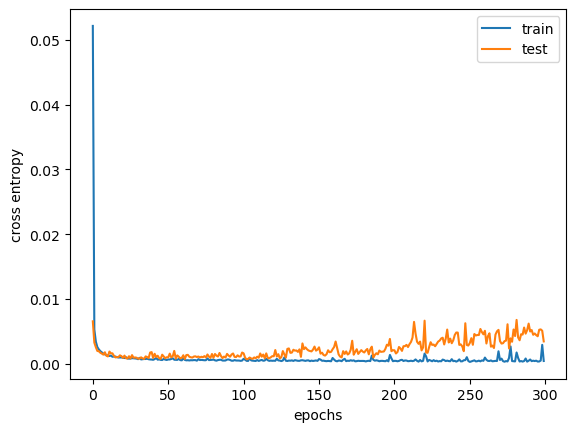

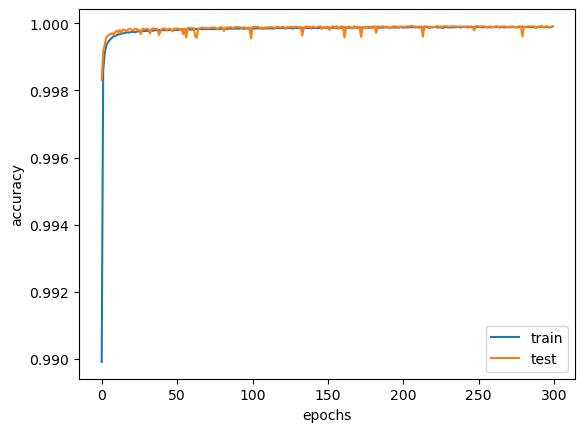

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/tmp/ipykernel_847152/109442466.py:52: UserWarning: Glyph 150 (\x96) missing from current font.
  plt.savefig('confusion_matrix.png')
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


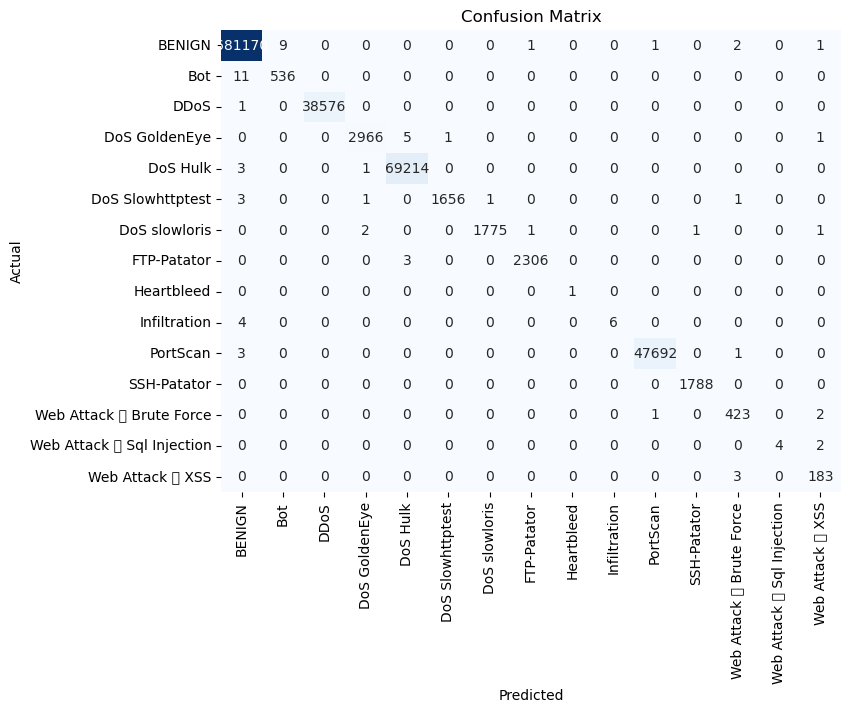

In [78]:
# Restore best model
model.load_state_dict(best_weights)

# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.savefig('cross_entropy.png')
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.savefig('accuracy.png')
plt.show()

model.eval()
with torch.no_grad():
    y_pred = model(X_test)

y_pred_classes = torch.argmax(y_pred, dim=1).cpu().numpy()
y_true_classes = torch.argmax(y_test, dim=1).cpu().numpy()

from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Assuming you have already computed the confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Define your custom class labels
# class_labels = ['normal', 'tcpfin', 'tcppush', 'tcprst', 'tcpsyn', 'udpflood']
class_labels = categories_as_list
# class_labels = [i for i in range(1, 16)]
# Create a heatmap of the confusion matrix with custom labels
categories_as_list = [item for sublist in categories for item in sublist]  # Flatten the categories list
class_labels = categories_as_list




plt.figure(figsize=(16, ))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()